# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import fbeta_score, make_scorer, recall_score
# magic word for producing visualizations in notebook
%matplotlib inline

def listFeaturesWithAllData( df ):
    '''
    Description: Method that returns a list with columns that 
    do not contain any missing values.
    
    Input: df - dataframe containing all features to be analyzed
   
    Output: returnlist - List containing the name of those features that have no 
            missing values
    '''
    internallist = list(df.loc[:,df.isna().sum() == 0].columns)
    returnlist = []
    for col in internallist:
        try:
            df[col].astype('float')
            returnlist.append(col)
        except ValueError:
            continue
    return returnlist

def listFeaturesNeedImputation( df ):
    '''
    Description: Method that returns a list with columns that 
    do contain missing values.
    
    Input: df - dataframe containing all features to be analyzed
   
    Output: returnlist - List containing the name of those features that have no 
            missing values
    '''
    internallist = list(df.loc[:,df.isna().sum() != 0].columns)
    returnlist = []
    for col in internallist:
        try:
            df[col].astype('float')
            returnlist.append(col)
        except ValueError:
            continue
    return returnlist

def changeinvalidToNan(df,invalidvalues_df, inplace=False):
    '''
    Description: It will take a dataframe containing invalid values
    and subsbtitute those values for np.nan in the df dataframe.
    
    Input: df - dataframe where invalid values are to be replaced by nans
           invalidvalues_df - dataframe containing invalid values per column
    
    Output: internaldf, which may be operations in place or on a separate dataframe
    '''
    internaldf = df.copy() if not inplace else df
    for col in invalidvalues_df.index:
        try:
            invalidValue = int(invalidvalues_df.loc[col])
            internaldf[col] = internaldf[col].replace({invalidValue:np.nan})
        except:
            splitlist = invalidvalues_df.loc[col,'invalid_values'].split(':')
            invalidValue1 = int(splitlist[0][1:])
            invalidValue2 = int(splitlist[1][:-1])
            internaldf[col] = internaldf[col].replace({invalidValue1:np.nan,invalidValue2:np.nan})
    return internaldf

def orderByMissingRatio(df,n,ascending=True):
    '''
    Description: Order the columns of a dataframe according to the number
    of missing cells. This ordering can be ascending or descending. Then
    filter the first few n and return a list with names
    
    Input: df - dataframe containing features to be analysed
           n - number of columns to be filtered
           ascending - whether the columns are filtered according to ascending
                       or descending order
    
    Output: internaldf, which may be operations in place or on a separate dataframe
    '''
    return (df.isna().sum(axis=0)/df.shape[0]).sort_values(ascending=ascending)[:n]

def differentitemsBetweenlists(list1,list2):
    '''
    Description: Return two list with names of items that are different
    between the first and the second list
    
    Input: list1 - list containing names of columns for a given dataframe
           list2 - list containing names of columns for a different dataframe
    
    Output: A first list with columns of the first list that do not appear on the second list
            A second list with columns of the second list that do not appear on the first list
    '''    
    return [x for x in list1 if x not in list2], [x for x in list2 if x not in list1]

def removeIndividuals(df,threshold):
    '''
    Description: Remove individuals/rows of a dataframe when they are missing more features 
    than the threshold indicated

    Input: df - dataframe that includes all those individuals that need to be removed
           threshold - number of features that would classify a feature as ready to be removed.

    Output: df - clean dataframe after removing rows that met criteria
    '''
    individualsToRemove = df[df.isna().sum(axis=1) >= threshold].index
    df = df.drop(index=individualsToRemove)
    return df

def removeColumns(dataframe, listcolumnstoremove):
    '''
    Description: Remove a list of columns from a dataframe

    Input: dataframe - dataframe that includes all those columns that need to be removed
           listcolumnstoremove - List of columns that should be removed

    Output: dattaframe - clean dataframe after removing columns that were not in the list
    '''
    if len(listcolumnstoremove) > 0:
        dataframe.drop(columns=listcolumnstoremove,inplace=True)
    return dataframe

def imputeNumericalColumns(df,columns_Y,columns_X):
    '''
    Description: A dataframe that contains missing information for columns Y and the end
    goal is to impute those missing values. In order to do so, a simple ML multiclass algorithm
    is used to predict values where they are missing.

    Input: df - dataframe that includes all features, both the ones with missing values and the ones used for training
           columns_Y - list of columns with missing values
           columns_X - list of features with all information
    '''
    # X represents the column where no data is missing
    X = df.loc[:,columns_X]
    for i,col in enumerate(columns_Y):
        # what is the feature to predict
        y = df.loc[:,col]
        # what are the indexes that we can use for training and those for prediction
        predictIndexes = y[y.isna()].index
        trainingIndexes = y[~y.isna()].index
        # Subset of X used for training
        Xpredict = X.loc[predictIndexes,:]
        Xtrain = X.loc[trainingIndexes,:]
        ytrain = y[trainingIndexes]
        # Random forest to imputate missing values
        model = RandomForestClassifier(n_estimators = 200)
        model = model.fit(Xtrain,ytrain)
        df.loc[predictIndexes,col] = model.predict(Xpredict)
        print('{}/{}'.format(i,len(columns_Y)))

def floatColsToInt(df):
    '''
    Description: Change float columns of a dataframe to int

    Input: df - dataframe that includes all float features
    '''    
    for col in df.columns:
        if df[col].dtype in [np.float16,np.float,np.float32,np.float64]:
            df[col] = df[col].astype('int')
            
def remapColumnCameoDeu(df):
    '''
    Description: Specific for CAMEO_DEU column. Map string values to numerical

    Input: df - dataframe that includes this feature
    '''    
    mappingDict = {'1A':0 ,'1B':1 ,'1C':2 ,'1D':3 ,'1E':4 ,'2A':5 ,'2B':6 ,'2C':7 ,'2D':8 ,'3A':9 ,'3B':10,'3C':11,'3D':12,
               '4A':13,'4B':14,'4C':15,'4D':16,'4E':17,'5A':18,'5B':19,'5C':20,'5D':21,'5E':22,'5F':23,'6A':24,'6B':25,
               '6C':26,'6D':27,'6E':28,'6F':29,'7A':30,'7B':31,'7C':32,'7D':33,'7E':34,'8A':35,'8B':36,'8C':37,'8D':38,
               '9A':39,'9B':40,'9C':41,'9D':42,'9E':43,'XX':np.nan,'X':np.nan}
    df['CAMEO_DEU_2015'] = df['CAMEO_DEU_2015'].replace(mappingDict)

def doStuffWithCameoIntl(df):
    '''
    Description: Engineer two features out of CAMEO_INTL and remove the original feature from the dataset

    Input: df - dataframe that includes CAMEO INTL feature
    '''        
    df['householdIncome'] = np.floor(df['CAMEO_INTL_2015'].replace({'X':np.nan,'XX':np.nan}).astype(float)/10)
    df['familytype'] = np.floor(df['CAMEO_INTL_2015'].replace({'X':np.nan,'XX':np.nan}).astype(float)%10)
    df.drop(columns = ['CAMEO_INTL_2015'],inplace=True)
    
remapColumnCameoDeug = lambda df: df.CAMEO_DEUG_2015.replace({'X':np.nan,'XX':np.nan})
remapColumnCameoDeug = lambda df: df.OST_WEST_KZ.replace({'O':0,'W':1})


def ETLPipelineSingleDf(pathtodf, pathdfclean, isTestDf = False):
    '''
    Description: ETL pipeline that loads two dataframes, transforms them (clean and wrangle)
    and ultimately loads the solution into a new csv file

    Input: pathAzdiasRaw - path to csv file containing raw information
           pathCustomersRaw - path to csv file containing raw information
           pathAzdiasClean - path where clean dataframe needs to be stored
           pathCustomersClean - path where clean dataframe needs to be stored
    '''    
    print('1 - Loading dataframes from csv files')
    azdias = pd.read_csv(pathtodf, sep=',').drop(columns=(['Unnamed: 0','LNR'] if isTestDf is False else ['Unnamed: 0']))
    
    invalid_values_df = pd.read_csv('invalidValues.csv').set_index('column_name')
    print('2 - Drop duplicates')
    azdias_clean = azdias.drop_duplicates()
    print('3 - Change invalid values to np.nan')
    azdias_clean = changeinvalidToNan(azdias_clean,invalid_values_df)
    indexThreshold = 50
    print('4 - Removing individuals with more than {} features missing'.format(indexThreshold))
    azdias_clean = removeIndividuals(azdias_clean,indexThreshold)
    colsToRemove = ['AGER_TYP', 'ALTER_HH', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'ALTERSKATEGORIE_FEIN', 'EXTSEL992', 'KBA05_BAUMAX', 'KK_KUNDENTYP', 'TITEL_KZ']
    print('5 - Removing features that are missing more than a number of invidivuals')
    azdias_clean = removeColumns(azdias_clean,colsToRemove)
    print('6 - Engineer the features that have string type')
    remapColumnCameoDeu(azdias_clean)
    azdias_clean['CAMEO_DEUG_2015'] = remapColumnCameoDeug(azdias_clean)
    doStuffWithCameoIntl(azdias_clean)
    azdias_clean.drop(columns=['D19_LETZTER_KAUF_BRANCHE','EINGEFUEGT_AM'],inplace=True)
    azdias_clean['OST_WEST_KZ'] = remapColumnCameoDeug(azdias_clean)
    print('7 - Now impute missing values for the numberical features. Num Rows: {}'.format(azdias_clean.shape[0]))
    columnsX = listFeaturesWithAllData(azdias_clean)
    columnsY = listFeaturesNeedImputation(azdias_clean)
    for col in columnsY:
        azdias_clean[col] = azdias_clean[col].astype('float')
    numnabeforeAz = azdias_clean.isna().sum().sum()
    imputeNumericalColumns(azdias_clean,columnsY,columnsX)
    print('8 - Change features that float to int')
    floatColsToInt(azdias_clean)
    print('9 - Load the cleaned dataframes onto csv files')
    azdias_clean.to_csv(pathdfclean,index=False)
    
    return azdias_clean

def ETLPipeline(pathAzdiasRaw,pathCustomersRaw, pathAzdiasClean, pathCustomersClean,):
    '''
    Description: ETL pipeline that loads two dataframes, transforms them (clean and wrangle)
    and ultimately loads the solution into a new csv file

    Input: pathAzdiasRaw - path to csv file containing raw information
           pathCustomersRaw - path to csv file containing raw information
           pathAzdiasClean - path where clean dataframe needs to be stored
           pathCustomersClean - path where clean dataframe needs to be stored
    '''    
    print('1 - Loading dataframes from csv files')
    azdias = pd.read_csv(pathAzdiasRaw, sep=',').drop(columns=['Unnamed: 0','LNR'])
    customers = pd.read_csv(pathCustomersRaw, sep=',').drop(columns=['Unnamed: 0','LNR'])
    
    invalid_values_df = pd.read_csv('invalidValues.csv').set_index('column_name')
    print('2 - Drop duplicates')
    azdias_clean = azdias.drop_duplicates()
    customers_clean = customers.drop_duplicates()
    print('3 - Change invalid values to np.nan')
    azdias_clean = changeinvalidToNan(azdias_clean,invalid_values_df)
    customers_clean = changeinvalidToNan(customers_clean,invalid_values_df)
    indexThreshold = 50
    print('4 - Removing individuals with more than {} features missing'.format(indexThreshold))
    customers_clean = removeIndividuals(customers_clean,indexThreshold)
    azdias_clean = removeIndividuals(azdias_clean,indexThreshold)
    colsToRemove = ['AGER_TYP', 'ALTER_HH', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'ALTERSKATEGORIE_FEIN', 'EXTSEL992', 'KBA05_BAUMAX', 'KK_KUNDENTYP', 'TITEL_KZ']
    print('5 - Removing features that are missing more than a number of invidivuals')
    customers_clean = removeColumns(customers_clean,colsToRemove)
    azdias_clean = removeColumns(azdias_clean,colsToRemove)
    print('6 - Engineer the features that have string type')
    remapColumnCameoDeu(azdias_clean)
    remapColumnCameoDeu(customers_clean)
    azdias_clean['CAMEO_DEUG_2015'] = remapColumnCameoDeug(azdias_clean)
    customers_clean['CAMEO_DEUG_2015'] = remapColumnCameoDeug(customers_clean)
    doStuffWithCameoIntl(azdias_clean)
    doStuffWithCameoIntl(customers_clean)
    azdias_clean.drop(columns=['D19_LETZTER_KAUF_BRANCHE','EINGEFUEGT_AM'],inplace=True)
    customers_clean.drop(columns=['D19_LETZTER_KAUF_BRANCHE','EINGEFUEGT_AM'],inplace=True)
    azdias_clean['OST_WEST_KZ'] = remapColumnCameoDeug(azdias_clean)
    customers_clean['OST_WEST_KZ'] = remapColumnCameoDeug(customers_clean)
    print('7 - Now impute missing values for the numberical features')
    columnsX = listFeaturesWithAllData(customers_clean)
    columnsY = listFeaturesNeedImputation(customers_clean)
    for col in columnsY:
        customers_clean[col] = customers_clean[col].astype('float')
    numnabeforeCust = customers_clean.isna().sum().sum()
    imputeNumericalColumns(customers_clean,columnsY,columnsX)
    columnsX = listFeaturesWithAllData(azdias_clean)
    columnsY = listFeaturesNeedImputation(azdias_clean)
    for col in columnsY:
        azdias_clean[col] = azdias_clean[col].astype('float')
    numnabeforeAz = azdias_clean.isna().sum().sum()
    imputeNumericalColumns(azdias_clean,columnsY,columnsX)
    print('8 - Change features that float to int')
    floatColsToInt(azdias_clean)
    floatColsToInt(customers_clean)
    print('9 - Load the cleaned dataframes onto csv files')
    customers_clean.to_csv(pathAzdiasClean,index=False)
    azdias_clean.to_csv(pathCustomersClean,index=False)
    
    return azdias_clean, customers_clean

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [3]:
# load in the data
azdias = pd.read_csv('../azdias.csv', sep=',').drop(columns=['Unnamed: 0','LNR'])
customers = pd.read_csv('../customers.csv', sep=',').drop(columns=['Unnamed: 0','LNR'])

C:\Users\alejanma\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


I've written a file with the invalid values for each column in the dataset. This will help calculate the number of missing values more precisely

In [4]:
invalid_values_df = pd.read_csv('invalidValues.csv').set_index('column_name')

Let's see to what extent the columns in both datasets are similar

In [5]:
# Are columns the same for both datasets
differentcolumns  = [x for x in azdias.columns if x not in customers.columns]
differentcolumns += [x for x in customers.columns if x not in azdias.columns]
print('Number of columns that are different between groups: {}'.format(len(differentcolumns)))
print('Name of columns that are different between datasets: {}'.format(differentcolumns))
print()
print('Size of customers dataset. Rows:{}, Columns:{}'.format(customers.shape[0],customers.shape[1]))
print('Size of azdias dataset. Rows:{}, Columns:{}'.format(azdias.shape[0],azdias.shape[1]))
print()
print('Number of duplicates. Customers: {}. Azdias: {}'.format(customers.duplicated().sum(), azdias.duplicated().sum()))

Number of columns that are different between groups: 3
Name of columns that are different between datasets: ['PRODUCT_GROUP', 'CUSTOMER_GROUP', 'ONLINE_PURCHASE']

Size of customers dataset. Rows:191652, Columns:368
Size of azdias dataset. Rows:891221, Columns:365

Number of duplicates. Customers: 41121. Azdias: 45762


In [6]:
# Since there are duplicate entries, let's remove the duplicates
azdias_clean = azdias.drop_duplicates()
customers_clean = customers.drop_duplicates()

Let's now modify both dataframes and substitute all those values that are not np.nan but actually are unknown as given by the invalid_values_df above. Then let's print a few columns to get a feel for how many values are missing in each column

In [7]:
azdias_clean = changeinvalidToNan(azdias,invalid_values_df)
customers_clean = changeinvalidToNan(customers,invalid_values_df)

# Now let's look at how many non na values there are per column.
print('Ratio of missing values per column for Customer dataset descending')
print(orderByMissingRatio(customers_clean,5,False))
print()
print('Ratio of missing values per column for Azdias dataset descending')
print(orderByMissingRatio(azdias_clean,5,False))
print()
print('Ratio of missing values per column for Customer dataset ascending')
print(orderByMissingRatio(customers_clean,100,True))
print()
print('Ratio of missing values per column for Azdias dataset ascending')
print(orderByMissingRatio(azdias_clean,100,True))

Ratio of missing values per column for Customer dataset descending
ALTER_KIND4    0.998769
ALTER_KIND3    0.993347
TITEL_KZ       0.987936
ALTER_KIND2    0.973389
ALTER_KIND1    0.938607
dtype: float64

Ratio of missing values per column for Azdias dataset descending
ALTER_KIND4    0.998648
TITEL_KZ       0.997576
ALTER_KIND3    0.993077
ALTER_KIND2    0.966900
ALTER_KIND1    0.909048
dtype: float64

Ratio of missing values per column for Customer dataset ascending
ALTERSKATEGORIE_GROB         0.000000
D19_VERSI_ANZ_12             0.000000
D19_VERSAND_REST             0.000000
D19_VERSAND_ONLINE_DATUM     0.000000
D19_VERSAND_OFFLINE_DATUM    0.000000
                               ...   
LP_FAMILIE_FEIN              0.016765
GFK_URLAUBERTYP              0.016765
CJT_KATALOGNUTZER            0.016765
LP_LEBENSPHASE_FEIN          0.016765
CJT_TYP_1                    0.016765
Length: 100, dtype: float64

Ratio of missing values per column for Azdias dataset ascending
ALTERSKATEGORIE_GRO

Above it can be seen that there are columns with more than 90% values missing. Let's see this information in a histogram

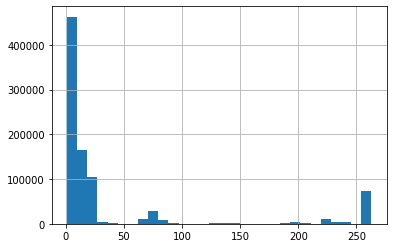

In [8]:
azdias_clean.isna().sum(axis=1).hist(bins=30);

Similarly, in the customer dataset all those  columns that contain 60k missing values seem outliers

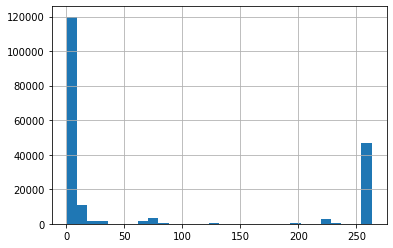

In [9]:
customers_clean.isna().sum(axis=1).hist(bins=30);

The above histograms show that there are individuals who are missing a lot of features. In particular it's worrying that for the customer dataset there are more than 40k individuals that are missing more than 250 columns. It seems to me that any individual that is missing more than 50 features should be removed as it's mainly an outlier. Let's do this on both datasets

In [10]:
indexThreshold = 50
previousnumindcustomer, previousnumindazdias = customers_clean.shape[0], azdias_clean.shape[0]
customers_clean = removeIndividuals(customers_clean,indexThreshold)
azdias_clean = removeIndividuals(azdias_clean,indexThreshold)
print("% of individuals removed in customer df: {}%".format(100*(1-customers_clean.shape[0]/previousnumindcustomer)))
print("% of individuals removed in azdias df: {}%".format(100*(1-azdias_clean.shape[0]/previousnumindazdias)))

% of individuals removed in customer df: 29.95324859641434%
% of individuals removed in azdias df: 17.272146863684767%


Now that problematic individuals are removed, let's check the opposite histograms. That is, what are the features that are misssing most individuals

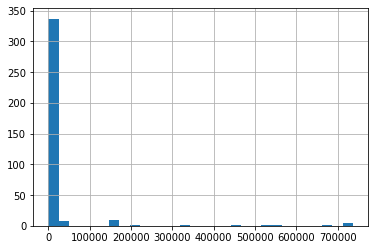

In [11]:
azdias_clean.isna().sum().hist(bins=30);

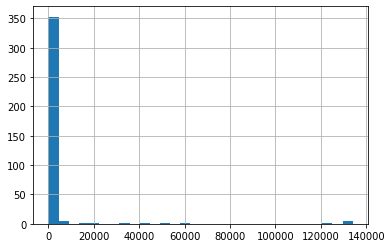

In [12]:
customers_clean.isna().sum().hist(bins=30);

The histograms above show that now most of the columns contain very few missing values. Still it seems that there are a few columns that look like outliers to me. Let's remove all those columns that contain more than 25% of missing values

After identifying the columns with more than 25% of values missing, then we will need to get the union of both sets of missing columns from both datasets and keep the list of valid columns. This is of importance to prepare the ETL pipeline later on

In [13]:
thresholdRatio = 0.25
ordercustomers = orderByMissingRatio(customers_clean,customers_clean.shape[0],False)
customerColsKeep = ordercustomers[ordercustomers < thresholdRatio].index
orderazdias = orderByMissingRatio(azdias_clean,azdias_clean.shape[0],False)
azdiasColsKeep = orderazdias[orderazdias < thresholdRatio].index

print('Number of customer columns to keep: {}'.format(len(customerColsKeep)))
print('Number of azdias columns to keep: {}'.format(len(azdiasColsKeep)))

l1,l2 = differentitemsBetweenlists(customerColsKeep,azdiasColsKeep)
print()
print(l1)
print()
print(l2)


Number of customer columns to keep: 359
Number of azdias columns to keep: 354

['ALTER_HH', 'ALTERSKATEGORIE_FEIN', 'PRODUCT_GROUP', 'CUSTOMER_GROUP', 'ONLINE_PURCHASE']

[]


In [14]:
ColsToKeep = list(set(customerColsKeep) & set(azdiasColsKeep))
ColsToKeep += ['PRODUCT_GROUP', 'CUSTOMER_GROUP', 'ONLINE_PURCHASE']
ColsToRemove = [col for col in customers_clean.columns if col not in ColsToKeep]
ColsToRemove

['AGER_TYP',
 'ALTER_HH',
 'ALTER_KIND1',
 'ALTER_KIND2',
 'ALTER_KIND3',
 'ALTER_KIND4',
 'ALTERSKATEGORIE_FEIN',
 'EXTSEL992',
 'KBA05_BAUMAX',
 'KK_KUNDENTYP',
 'TITEL_KZ']

Let's remove any column that it's not present under ColsToKeep

In [15]:
customers_clean = removeColumns(customers_clean,ColsToRemove)
azdias_clean = removeColumns(azdias_clean,ColsToRemove)
customers_clean.shape, azdias_clean.shape

((134246, 357), (737288, 354))

So far we've removed all those individuals and features that were outliers as far as how much information they were missing. Now, the resulting dataframes contain missing information that is more manageable. We now need to inspect the dataframes to find out problems with types, perhaps engineer some features, etc.
Ultimately we will need to impute the missing values, we will see a few approaches for this

In [16]:
# Impute values for customer df
columnsX = listFeaturesWithAllData(customers_clean)
columnsY = listFeaturesNeedImputation(customers_clean)
numnabeforeCust = customers_clean.isna().sum().sum()
imputeNumericalColumns(customers_clean,columnsY,columnsX)
# Impute values for az df
print()
print('Starting azdias df')
columnsX = listFeaturesWithAllData(azdias_clean)
columnsY = listFeaturesNeedImputation(azdias_clean)
numnabeforeAz = azdias_clean.isna().sum().sum()
imputeNumericalColumns(azdias_clean,columnsY,columnsX)

0/64
1/64
2/64
3/64
4/64
5/64
6/64
7/64
8/64
9/64
10/64
11/64
12/64
13/64
14/64
15/64
16/64
17/64
18/64
19/64
20/64
21/64
22/64
23/64
24/64
25/64
26/64
27/64
28/64
29/64
30/64
31/64
32/64
33/64
34/64
35/64
36/64
37/64
38/64
39/64
40/64
41/64
42/64
43/64
44/64
45/64
46/64
47/64
48/64
49/64
50/64
51/64
52/64
53/64
54/64
55/64
56/64
57/64
58/64
59/64
60/64
61/64
62/64
63/64

Starting azdias df
0/66
1/66
2/66
3/66
4/66
5/66
6/66
7/66
8/66
9/66
10/66
11/66
12/66
13/66
14/66
15/66
16/66
17/66
18/66
19/66
20/66
21/66
22/66
23/66
24/66
25/66
26/66
27/66
28/66
29/66
30/66
31/66
32/66
33/66
34/66
35/66
36/66
37/66
38/66
39/66
40/66
41/66
42/66
43/66
44/66
45/66
46/66
47/66
48/66
49/66
50/66
51/66
52/66
53/66
54/66
55/66
56/66
57/66
58/66
59/66
60/66
61/66
62/66
63/66
64/66
65/66


## Now the idea is to clean the string columns

Now let's change float columns to ints as they are all categorical

In [17]:
floatColsToInt(azdias_clean)
floatColsToInt(customers_clean)

Let's see what are the columns that are not numerical

In [18]:
for col in azdias_clean.columns:
    if azdias_clean[col].dtype == np.object:
        print(col)

CAMEO_DEU_2015
CAMEO_DEUG_2015
CAMEO_INTL_2015
D19_LETZTER_KAUF_BRANCHE
EINGEFUEGT_AM
OST_WEST_KZ


### CAMEO_DEU_2015

This column indicates the type of person a particular individual is. There are many categories that could take numbers only as well. Alternatively, we could use one-hot encoding for this column too. The problem with one hot encoding is that it increases the number of columns of the whole dataset very quickly and we've already got a few of these. Let's just get this classification to a number scale.

In [19]:
remapColumnCameoDeu(azdias_clean)
remapColumnCameoDeu(customers_clean)

### CAMEO_DEUG_2015
There are some values that are X... Let's change this to np.nan

In [20]:
azdias_clean['CAMEO_DEUG_2015'] = remapColumnCameoDeug(azdias_clean)
customers_clean['CAMEO_DEUG_2015'] = remapColumnCameoDeug(customers_clean)

### CAMEO_INTL_2015

Same as before but now with XX. In addition to the above it seems that for this feature two different types of data are encoded into 1. Let's engineer two features out of this column

In [21]:
azdias_clean.CAMEO_INTL_2015

1         51
2         24
3         12
4         43
5         54
          ..
891216    41
891217    51
891218    24
891219    51
891220    43
Name: CAMEO_INTL_2015, Length: 737288, dtype: object

In [22]:
doStuffWithCameoIntl(azdias_clean)
doStuffWithCameoIntl(customers_clean)

### D19_LETZTER_KAUF_BRANCHE and EINGEFUEGT_AM

Values of these don't seem to be of much interest... and I couldn't get any interpretation on the spread sheets, so remove them

In [23]:
azdias_clean.D19_LETZTER_KAUF_BRANCHE.value_counts()[:5]

D19_UNBEKANNT         179081
D19_VERSICHERUNGEN     52220
D19_SONSTIGE           40546
D19_VOLLSORTIMENT      31292
D19_SCHUHE             28486
Name: D19_LETZTER_KAUF_BRANCHE, dtype: int64

In [24]:
azdias_clean.drop(columns=['D19_LETZTER_KAUF_BRANCHE','EINGEFUEGT_AM'],inplace=True)
customers_clean.drop(columns=['D19_LETZTER_KAUF_BRANCHE','EINGEFUEGT_AM'],inplace=True)

### OST_WEST_KZ

Finally, we can map O to 0 and W to 1

In [25]:
azdias_clean['OST_WEST_KZ'] = remapColumnCameoDeug(azdias_clean)
customers_clean['OST_WEST_KZ'] = remapColumnCameoDeug(customers_clean)

Now, these few columns that we've modified contain np.nan values that we need to impute. Let's proceed as before making use of an ML model to impute a category for the missing values

In [26]:
# Impute values for customer df
columnsX = listFeaturesWithAllData(customers_clean)
columnsY = listFeaturesNeedImputation(customers_clean)
for col in columnsY:
    customers_clean[col] = customers_clean[col].astype('float')
numnabeforeCust = customers_clean.isna().sum().sum()
imputeNumericalColumns(customers_clean,columnsY,columnsX)

0/3
1/3
2/3


In [27]:
# Impute values for azdias df
columnsX = listFeaturesWithAllData(azdias_clean)
columnsY = listFeaturesNeedImputation(azdias_clean)
for col in columnsY:
    azdias_clean[col] = azdias_clean[col].astype('float')
numnabeforeAz = azdias_clean.isna().sum().sum()
imputeNumericalColumns(azdias_clean,columnsY,columnsX)

0/3
1/3
2/3


In [28]:
print('Before: {}. Now: {}'.format(numnabeforeCust,customers_clean.isna().sum().sum()))
print('Before: {}. Now: {}'.format(numnabeforeAz,azdias_clean.isna().sum().sum()))

Before: 900. Now: 0
Before: 10020. Now: 0


In [29]:
customers_clean.to_csv('customersAllClean.csv',index=False)
azdias_clean.to_csv('azdiasAllClean.csv',index=False)

In [30]:
#az_df,cu_df = ETLPipeline('../azdias.csv','../customers.csv','azdiasAllClean.csv','customersAllClean.csv')

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

Let's read the cleaned datasets

In [17]:
customers_clean = pd.read_csv('customersAllClean.csv')
azdias_clean = pd.read_csv('azdiasAllClean.csv') 

customers_clean['PRODUCT_GROUP'] = customers_clean['PRODUCT_GROUP'].replace({'COSMETIC_AND_FOOD':0,'COSMETIC':1,'FOOD':2})
customers_clean['CUSTOMER_GROUP'] = customers_clean['CUSTOMER_GROUP'].replace({'MULTI_BUYER':0,'SINGLE_BUYER':1})
customers_clean['PRODUCT_GROUP'] = customers_clean['PRODUCT_GROUP'].astype('int')
customers_clean['CUSTOMER_GROUP'] = customers_clean['CUSTOMER_GROUP'].astype('int')
customers_clean['ONLINE_PURCHASE'] = customers_clean['ONLINE_PURCHASE'].astype('int')

The number of columns in the dataset is too large, and clustering takes a long time. By reducing the number of features using PCA the amount of time to do the clustering is reduced without sacrifing a lot of information loss.

However, before we can proceed with the principal component analysis we need to scale the data. 

It's important to remark that all the next steps will be done on the whole population dataset and whatever the transformers and predictors learn from the whole population will be applied to the customer dataset

In [18]:
scaler = StandardScaler()
azdias_scaled = scaler.fit_transform(azdias_clean)

Now that the dataframe is scaled, let's run PCA on it and let's see how each component contributes to explaining the variabliity of the data

In [19]:
mypca = PCA()
azdias_pcaed = mypca.fit_transform(azdias_scaled)

Let's plot the results

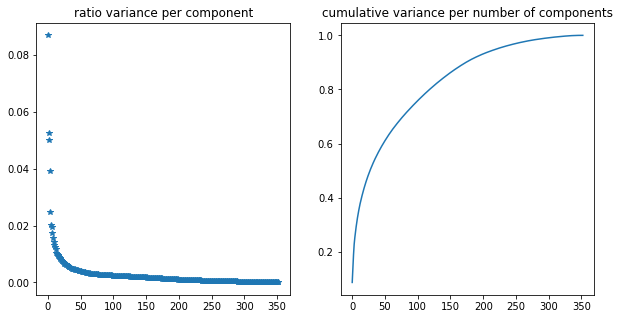

In [20]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title('ratio variance per component')
plt.plot(mypca.explained_variance_ratio_,'*')
plt.subplot(1,2,2)
plt.title('cumulative variance per number of components')
plt.plot(mypca.explained_variance_ratio_.cumsum())

The curves above take the expected shape with the first few principal components explaining most of the dataset's variability. However, so as to know how many components to keep, let's take a zoomed picture on the area between 30 and 100 components as it's seems there is a bit of an elbow there

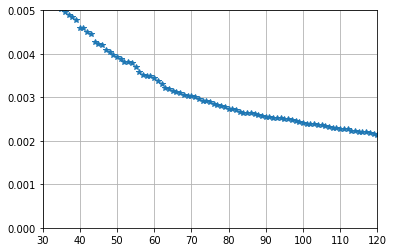

In [21]:
plt.plot(mypca.explained_variance_ratio_,'*')
plt.axis([30,120, 0, 0.005]);
plt.grid()
# Keep 70

The picture above shows that around 70 compoennts there is a bit of an elbow. It corresponds to a 0.3% of variability explained by that last component. Let's therefore keep 70 compoennts for the ensuing analysis

In [22]:
mypca = PCA(n_components=70)
azdias_pcaed = mypca.fit_transform(azdias_scaled)

Just out of pure curiosity, let's see what the first component represents. Below there is a plot that takes the first 5 features that are directly proportional contributors and also the 5 that are indirectly proportional contributors

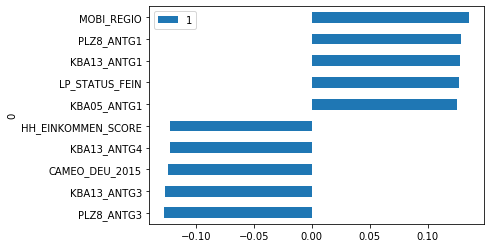

In [23]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
def featurefromcomponentAnalysis(componentvector, listcolumns,compNumber):
    return sorted([(col,comp) for col,comp in zip(listcolumns,componentvector[compNumber])],key=lambda x: x[1])

resultsFirst = featurefromcomponentAnalysis(mypca.components_,azdias_clean.columns,0)
tmpdf = pd.DataFrame(resultsFirst[0:5] + resultsFirst[-5:])#.plot(kind='barh')
tmpdf =tmpdf.set_index(tmpdf[0]).drop(columns=0)
tmpdf.plot(kind='barh')

MOBI_REGIO - moving patterns, very high mobility - very low mobility     
PLZ8-ANTG1 - number of 1-2 familiyt houses: none - very high share    
LP_STATUS_FEIN - social status : typical low-income - top earners    
PLZ8_ANTG3 - number of 6-10 family houses in the PLZ8: none - high share    
HH_EINKOMMEN_SCORE - INCOME - highest income, very low income    

So overall it seems that the principal compoent is associated with high earners that live in areas where there are small families and they themselves have not got a big family either

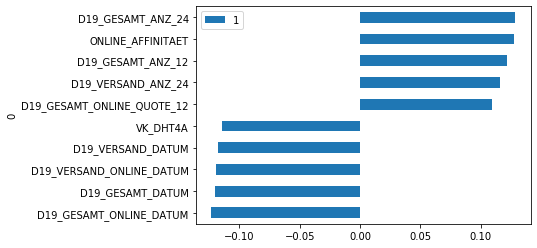

In [24]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
resultsSecond = featurefromcomponentAnalysis(mypca.components_,azdias_clean.columns,1)
tmpdf = pd.DataFrame(resultsSecond[0:5] + resultsSecond[-5:])#.plot(kind='barh')
tmpdf =tmpdf.set_index(tmpdf[0]).drop(columns=0)
tmpdf.plot(kind='barh')

On the other hand the second component is more about online activity and how keen each individual is on making online transactions

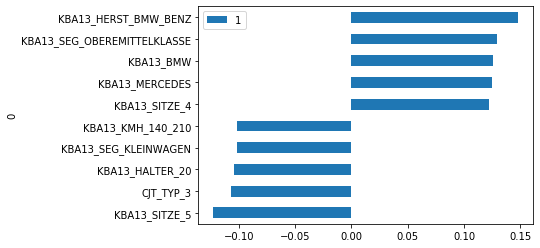

In [25]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
resultsSecond = featurefromcomponentAnalysis(mypca.components_,azdias_clean.columns,2)
tmpdf = pd.DataFrame(resultsSecond[0:5] + resultsSecond[-5:])#.plot(kind='barh')
tmpdf =tmpdf.set_index(tmpdf[0]).drop(columns=0)
tmpdf.plot(kind='barh')

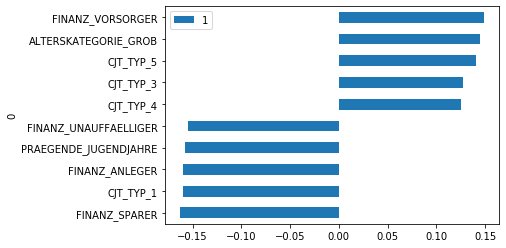

In [26]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
resultsSecond = featurefromcomponentAnalysis(mypca.components_,azdias_clean.columns,3)
tmpdf = pd.DataFrame(resultsSecond[0:5] + resultsSecond[-5:])#.plot(kind='barh')
tmpdf =tmpdf.set_index(tmpdf[0]).drop(columns=0)
tmpdf.plot(kind='barh')

Now htat the amount of features has been reduced, let's do an analysis on how many clusters make sense to have using KMeans clustering technique

In [27]:
# Over a number of different cluster counts...
results = []
# Append results in a list to ease plotting in the following cell
if 1:
    for nclusters in range(2,15):
        print(nclusters)
        myclustering = KMeans(n_clusters=nclusters)
        # run k-means clustering on the data and...
        myclustering.fit(azdias_pcaed)

        # compute the average within-cluster distances.
        results.append(myclustering.score(azdias_pcaed)*-1)

2
3
4
5
6
7
8
9
10
11
12
13
14


Let's plot the information calculated above. Also, let's draw a red line to find out where the elbow is and so it will help us calculate the number of clusters to use

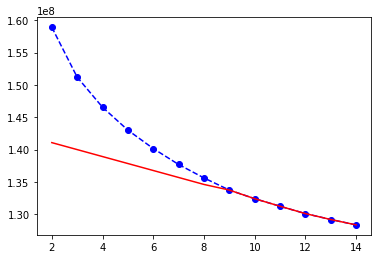

In [28]:
if 1:
    plt.plot(list(range(2,15)),results,linestyle='--', marker='o', color='b')
    plt.plot()

model = LinearRegression()
model.fit(X=np.asarray([[9,10,11,12,13,14]]).reshape(6,1), y=results[7:14])
predicted =model.predict(np.asarray(range(2,9)).reshape(-1,1))
plt.plot(list(range(2,15)),np.asarray(list(predicted.reshape(-1,1)) + list(results[7:14])),'r')

Given the above, it seems that 9 clusters is the right amount of clusters in which to divide the whole population. Let's therefore use n_clusters = 9 and work with that number

In [29]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
# Given the graph above the elbow seems to be at k=8 clusters
myclustering = KMeans(n_clusters=9)
myclustering.fit(azdias_pcaed)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=9, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [30]:
# Get a few predictions to check that it works
myclustering.predict(azdias_pcaed[100:107,:])

array([8, 3, 2, 2, 3, 2, 2])

Now that we've got all transformers and predictors trained, let's remove the columns from the customers dataset that are different to the whole population dataset and use the transformers to get a modified customers dataset

In [31]:
customers_clean2 = customers_clean.drop(columns=['PRODUCT_GROUP','CUSTOMER_GROUP','ONLINE_PURCHASE'])
customers_clean2 = scaler.transform(customers_clean2)
customers_clean2 = mypca.transform(customers_clean2)
customers_clusters = myclustering.predict(customers_clean2)

Now, let's compare the proportion of data in each cluster for both the customer dataset and the population's dataset

In [32]:
myl = [1,4,2,5,7]
myl.index(7)

4

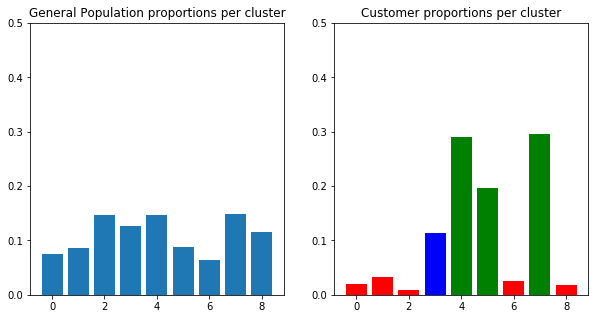

In [33]:
# predict clusters for all individuals in the general population
predict_generalpop = myclustering.predict(azdias_pcaed)
predict_generalpop.shape, customers_clusters.shape
# create a dataframe to use pandas methods
generalpop = pd.DataFrame(predict_generalpop)
# get each cluster's proportion
generalpopProportions = generalpop[0].value_counts()/generalpop.shape[0]
# Do similarly for the customer dataset
customerbase = pd.DataFrame(customers_clusters)
customerProportions = customerbase[0].value_counts()/customerbase.shape[0]
# Sort the dataframes using the index
customerProportions = customerProportions.sort_index()
generalpopProportions = generalpopProportions.sort_index()
overrepresentedclusterList= list((customerProportions/generalpopProportions).sort_values(ascending = False).index)
colors = []
for i in range(9):
    colors.append('r' if overrepresentedclusterList.index(i) > 3 else 'g' if overrepresentedclusterList.index(i) < 3 else 'b')
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.bar(x=generalpopProportions.index,height=np.asarray(generalpopProportions))
xmin,xmax,ymin,ymax = plt.axis()
plt.axis([xmin,xmax,0,0.5])
plt.title('General Population proportions per cluster')
plt.subplot(1,2,2)
plt.bar(x=customerProportions.index,height=np.asarray(customerProportions),color=colors)
plt.axis([xmin,xmax,0,0.5])
plt.title('Customer proportions per cluster')
overrepresentedclusterList = overrepresentedclusterList[0:3]

So the graph above can be analysed as follows:

- There are three clusters from the overall population that are more likely to be customers for this company. These are clusters number 1, 3 and 4.

- There is one cluster that it's pretty much represented equally in both datasets.

- Five clusters (number 0, 5, 6, 7 and 8) are underrepresented in the customer dataset. This means that these groups are unlikely to be customers of this company

In order to find out what are the characteristics of each cluster, let's look at the features that are more relevant to describe each of them.

In particular we'll be looking at the features that help explain the first three principal components, both positively and negatively correlated. These features are

Positively correlated
- MOBI_REGIO
- PLZ8_ANT1
- D19_GESAMT_ANZ_24
- ONLINE_AFFINITAET
- KBA13_HERST_BMW_BENZ
- KBA13_SEG_OBEREMITTELKLASSE

Negatively correlated
- KBA13_ANTG3
- HH_EINKOMMEN_SCORE
- D19_GESAMT_ONLINE_DATUM
- VK_DHT4A
- KBA13_SITZE_5
- CJT_TYP_3

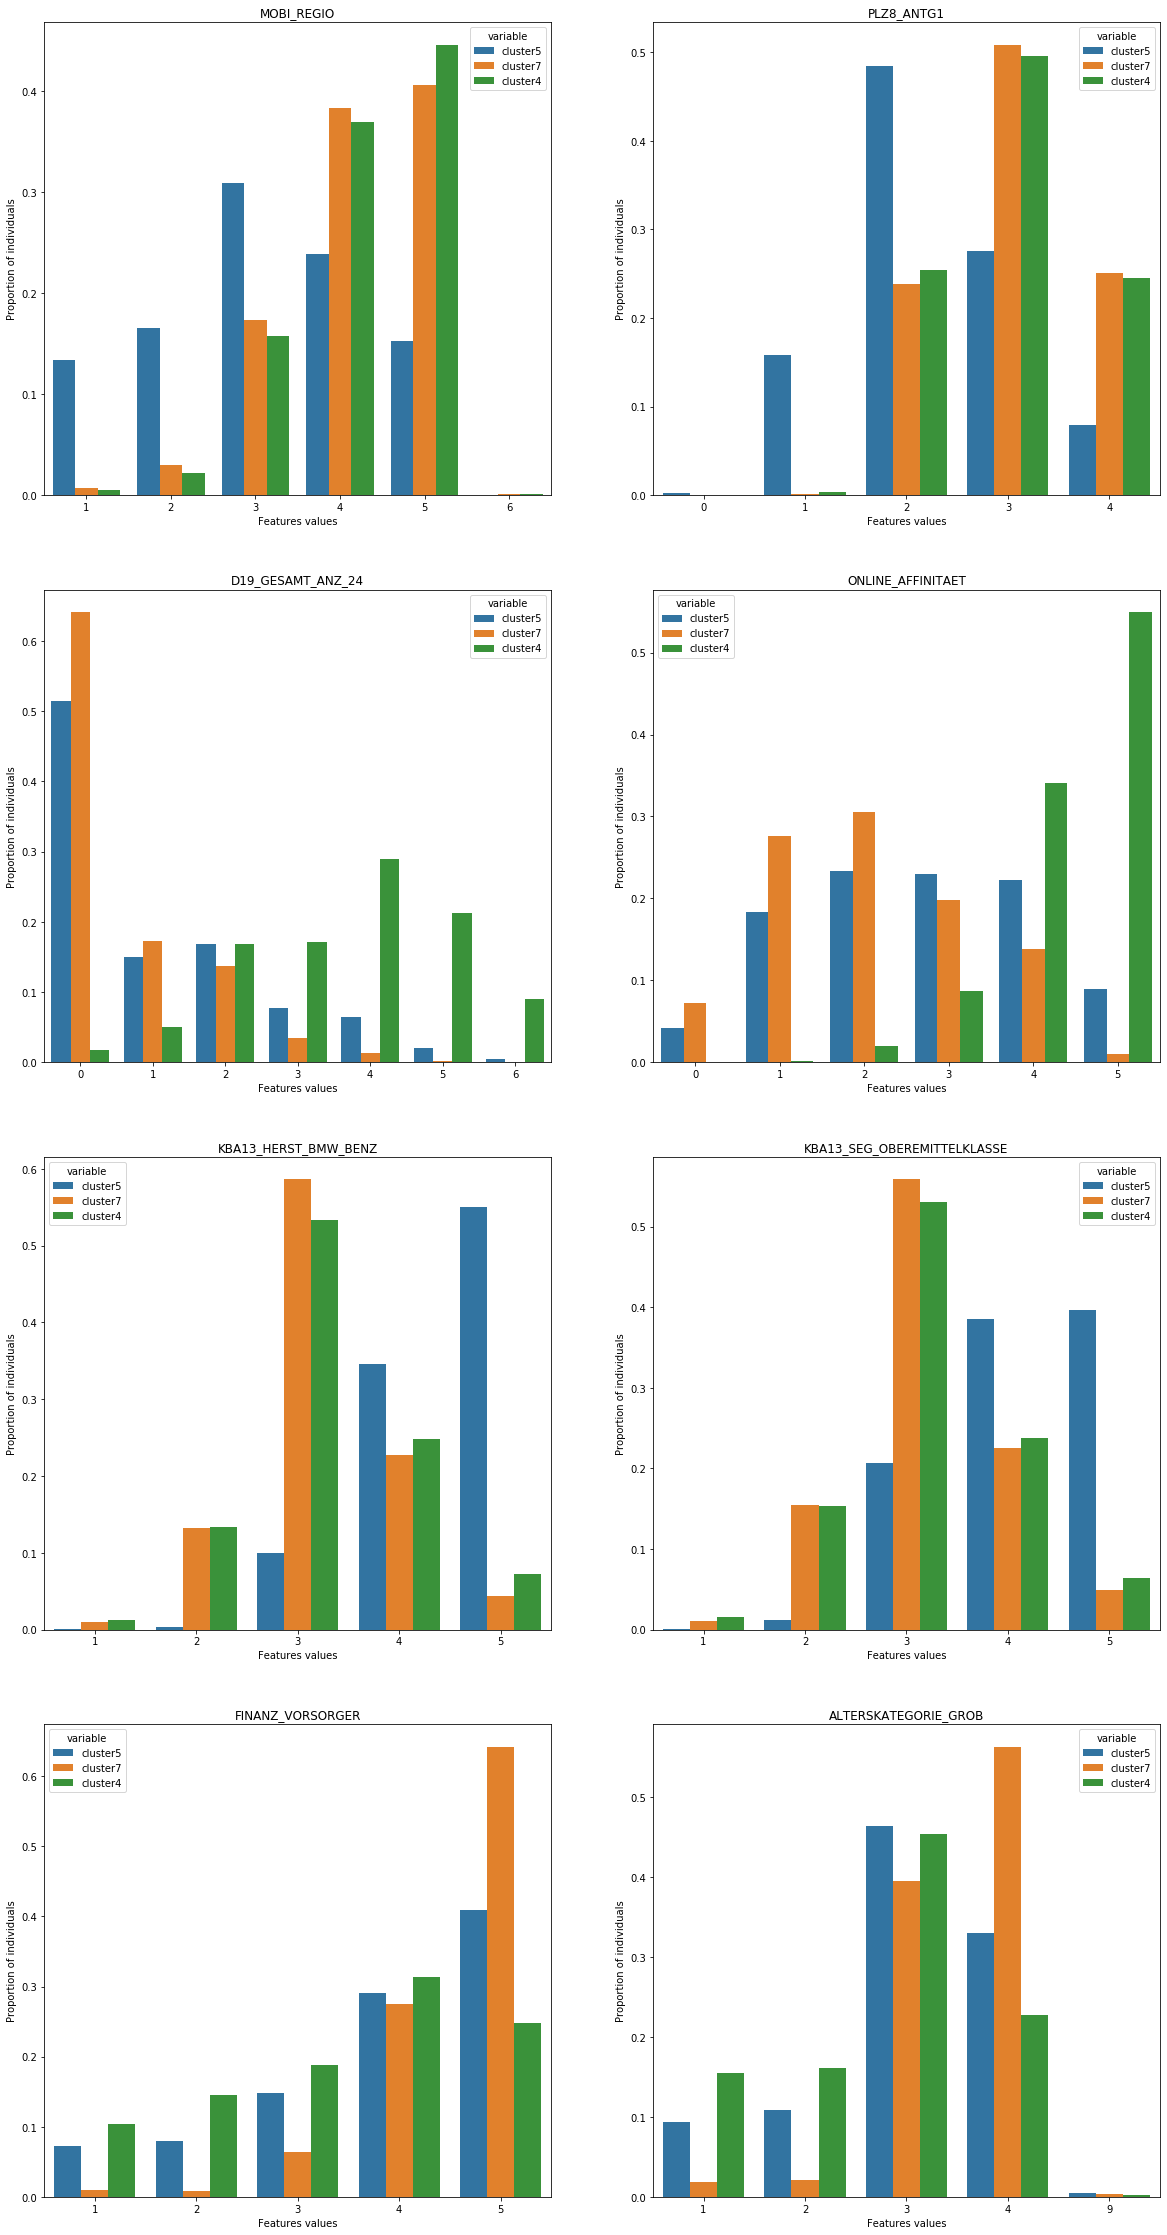

In [34]:
def extractindividualsFromCluster(df_genpop,predict_generalpop,clusternumber):
    genpop = pd.DataFrame(predict_generalpop)
    return df_genpop[predict_generalpop==clusternumber]

def valueCountsPerCluster(df,feature,clusterlist,predict_generalpop):
    cluster = extractindividualsFromCluster(df,predict_generalpop,clusterlist[0])[feature].value_counts().reset_index().sort_values(['index']).set_index('index').rename(columns={feature:'cluster{}'.format(clusterlist[0])})
    cluster = cluster/cluster.sum()
    
    for clusternum in clusterlist[1:]:
        clustertmp = extractindividualsFromCluster(df,predict_generalpop,clusternum)[feature].value_counts().reset_index().sort_values(['index']).set_index('index').rename(columns={feature:'cluster{}'.format(clusternum)})
        clustertmp = clustertmp/clustertmp.sum()
        cluster = cluster.merge(clustertmp, how='outer', left_index=True, right_index=True)
    return pd.melt(cluster.reset_index(),['index'])

#valueCountsPerCluster(azdias_clean,'MOBI_REGIO',[3,4,6],predict_generalpop).plot.bar(title='MOBI_REGIO');
#sns.barplot(valueCountsPerCluster(azdias_clean,'MOBI_REGIO',[3,4,6],predict_generalpop))
features = ['MOBI_REGIO','PLZ8_ANTG1','D19_GESAMT_ANZ_24','ONLINE_AFFINITAET','KBA13_HERST_BMW_BENZ','KBA13_SEG_OBEREMITTELKLASSE','FINANZ_VORSORGER', 'ALTERSKATEGORIE_GROB']
plt.figure(figsize=(20,len(features)/2*10))
for i,feature in enumerate(features):
    plt.subplot(len(features)/2,2,i+1)
    dftoplot = valueCountsPerCluster(azdias_clean,feature,overrepresentedclusterList,predict_generalpop)
    sns.barplot(data=dftoplot,x='index',y='value',hue='variable')
    plt.title(feature)
    plt.xlabel('Features values')
    plt.ylabel('Proportion of individuals')
    
    

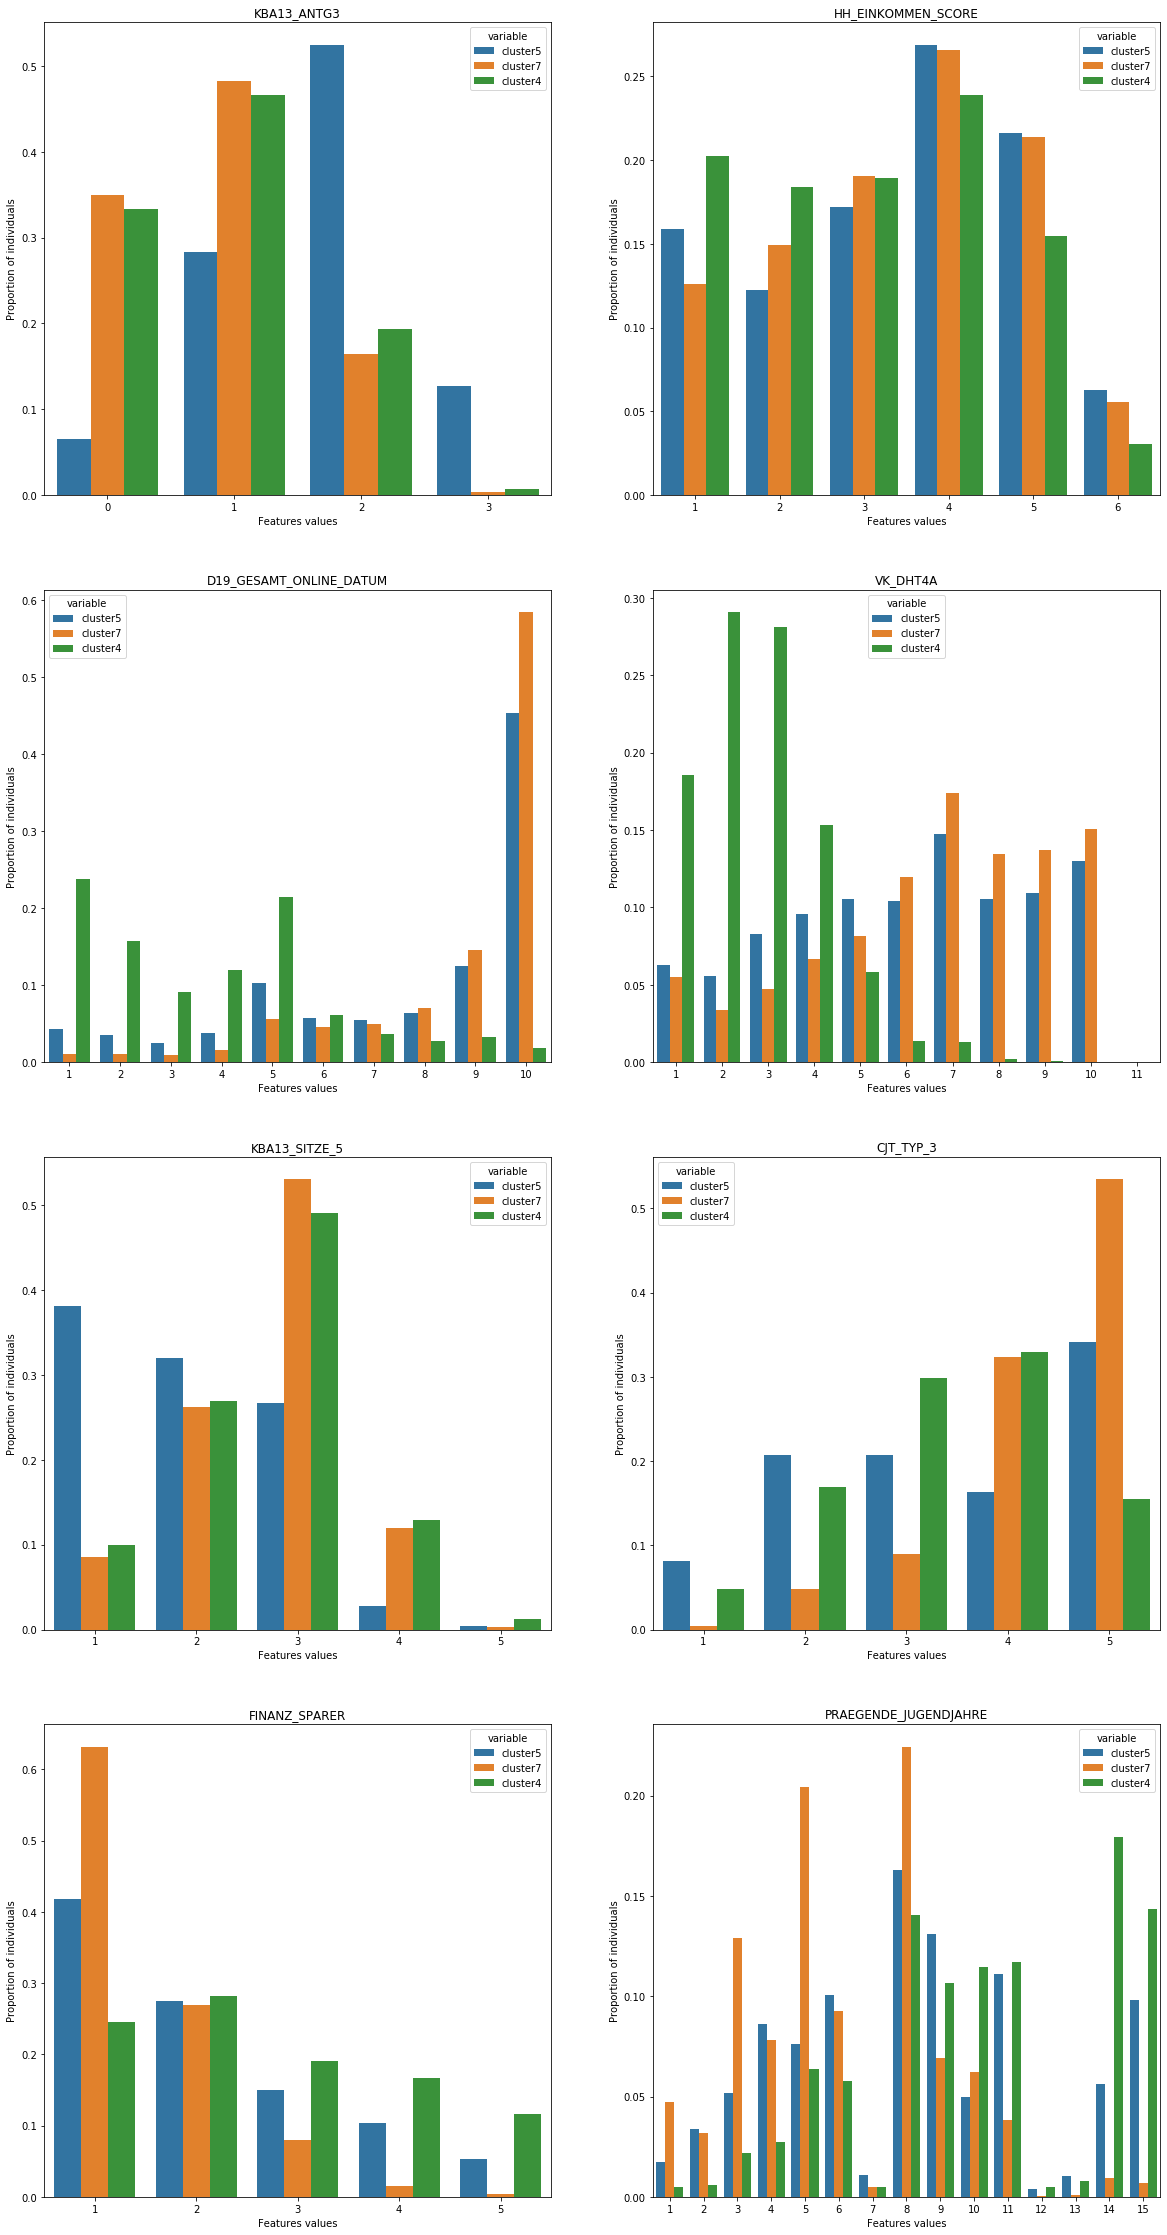

In [35]:
features = ['KBA13_ANTG3','HH_EINKOMMEN_SCORE','D19_GESAMT_ONLINE_DATUM','VK_DHT4A','KBA13_SITZE_5','CJT_TYP_3','FINANZ_SPARER', 'PRAEGENDE_JUGENDJAHRE']
plt.figure(figsize=(20,len(features)/2*10))
for i,feature in enumerate(features):
    plt.subplot(len(features)/2,2,i+1)
    dftoplot = valueCountsPerCluster(azdias_clean,feature,overrepresentedclusterList,predict_generalpop)
    sns.barplot(data=dftoplot,x='index',y='value',hue='variable')
    plt.title(feature)
    plt.xlabel('Features values')
    plt.ylabel('Proportion of individuals')

It was observed above, that there are three clusters that are overrepresented when compared to the others. Also there is a cluster that is similarly represented in both population and customer datasets.

If the company wants to target individuals of the whole population, ideally it should start with those individuals that are not customers already but are part of the overrepresented clusters as this indicates that the probability of them becoming customers is higher. Therefore there are three clusters that we will pay attention to. Cluster numbers appear in the legend for each plot and they are ordered according to the most overrepresented to the least overrepresented.

The first set of plots contains the two main features that contribute to explain each of the four first principal components. What each principal component is about has been described above. 
The second set of plots contains two main negative features for each of the principal components

The most overrepresented cluster seems to indicate that individuals meet the following description
 - Individuals with certain amount of mobility
 - That live in areas with an average number of neighbours
 - The number of transactions for these individuals in the past has been low or very low
 - They've got a moderate use of the internet
 - They like have a high share of middle class and upper class cars
 - This group of people does not seem to have a lot in cash (this is my interpretation of "be prepared")
 - This group's age is around 50 years old
 - Income-wise this group could be clasified as average/above average


The second most overrepresented cluster
 - Individuals with little or no mobility
 - That live in areas where there are with very few or no neighbours
 - The number of transactions for these individuals in the past has been low or very low
 - They've got low to moderate use of the internet
 - They don't seem to have a higher than average share of expensive cars
 - This group of people does not seem to have a lot in cash (this is my interpretation of "be prepared")
 - This group's age is around 65 years old
 - Income-wise this group could be clasified as average/above average
 
Finally, a description for the third most overreprented cluster
 - Individuals with little or no mobility
 - That live in areas where there are with very few or no neighbours
 - The number of transactions for these individuals in the past has been moderate to high
 - They are very active online
 - They don't seem to have a higher than average share of expensive cars
 - This group of people does not seem to have a lot in cash (this is my interpretation of "be prepared")
 - This group's age is around 45 years old
 - Income-wise this group could be clasified as above average

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [36]:
df_train = ETLPipelineSingleDf('../train.csv','../trainClean.csv')

1 - Loading dataframes from csv files


C:\Users\alejanma\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3248: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


2 - Drop duplicates
3 - Change invalid values to np.nan
4 - Removing individuals with more than 50 features missing
5 - Removing features that are missing more than a number of invidivuals
6 - Engineer the features that have string type
7 - Now impute missing values for the numberical features. Num Rows: 33836
0/65
1/65
2/65
3/65
4/65
5/65
6/65
7/65
8/65
9/65
10/65
11/65
12/65
13/65
14/65
15/65
16/65
17/65
18/65
19/65
20/65
21/65
22/65
23/65
24/65
25/65
26/65
27/65
28/65
29/65
30/65
31/65
32/65
33/65
34/65
35/65
36/65
37/65
38/65
39/65
40/65
41/65
42/65
43/65
44/65
45/65
46/65
47/65
48/65
49/65
50/65
51/65
52/65
53/65
54/65
55/65
56/65
57/65
58/65
59/65
60/65
61/65
62/65
63/65
64/65
8 - Change features that float to int
9 - Load the cleaned dataframes onto csv files


This is a very very unbalance dataset... accuracy is probably not the best metric to optimize. Instead, the idea is to have a good recall so we categorize as 1 all those that are trully 1s.

In [37]:
df_train.RESPONSE.value_counts()[1]/df_train.shape[0]

0.012294597470150137

I've used gradient boosting a number of times with excelent results. It performs better than random forest in most cases and it's been widely used by Kaggle contest winners. So let's create a model where a few parameters need to be fine-tuned to get the best model possible.

In [38]:
def addClusterCol(df,colsToDrop,scaler,mypca,myclustering):
    df2 = df.drop(columns=colsToDrop)
    df2 = scaler.transform(df2)
    df2 = mypca.transform(df2)
    df['cluster'] = myclustering.predict(df2)
    return df

def buildModel():
    pipeline = Pipeline([
    ('clf', GradientBoostingClassifier(random_state=0))
    ])

    parameters = {
        'clf__learning_rate': [0.005,0.01,0.05],
        'clf__n_estimators': [200,300,350,400],
        'clf__max_depth': list(range(4,12,2)) }
    scorer = make_scorer(recall_score)
    cv = GridSearchCV(pipeline, param_grid=parameters,scoring=scorer,cv=3,verbose=1,n_jobs=4)

    return cv

Since the dataset is so unbalance, let's create one dataframe where we've got more equal numbers between positive and negative responses. The problem with using all training data is that it will likely overfit for negative response even if the scorer selected for cross validation is "recall". Let's get all positive responses and twice as many negative responses and collect those into a new dataset.

In [44]:
# Tweak the dataset so we've got a more balanced dataset
df_train = pd.read_csv('../trainClean.csv')

df1 = df_train[df_train['RESPONSE'] == 1]
df2 = df_train[df_train['RESPONSE'] != 1]
df2 = df2.sample(df1.shape[0]*2)
df3 = pd.concat([df1,df2])

# Add the cluster column from the previous part as this is our new engineered feature
df_train = addClusterCol(df3,['RESPONSE'],scaler,mypca,myclustering)
# Let's split the dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(df3.drop(columns='RESPONSE'),  df3['RESPONSE'], random_state=1,test_size=0.1)
# Build a model using a pipeline and grid search
model = buildModel()
# Train the model
model.fit(X_train,y_train)
# Get the best estimator
best_clf = model.best_estimator_
# Calculate the recall score
pred= best_clf.predict(X_test)
print('recall score: {}'.format(recall_score(y_test,pred)))
best_clf

Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  2.3min
[Parallel(n_jobs=4)]: Done 144 out of 144 | elapsed:  7.8min finished


recall score: 0.5348837209302325


Pipeline(memory=None,
         steps=[('clf',
                 GradientBoostingClassifier(criterion='friedman_mse', init=None,
                                            learning_rate=0.01, loss='deviance',
                                            max_depth=6, max_features=None,
                                            max_leaf_nodes=None,
                                            min_impurity_decrease=0.0,
                                            min_impurity_split=None,
                                            min_samples_leaf=1,
                                            min_samples_split=2,
                                            min_weight_fraction_leaf=0.0,
                                            n_estimators=200,
                                            n_iter_no_change=None,
                                            presort='auto', random_state=0,
                                            subsample=1.0, tol=0.0001,
                                

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [40]:
df_test = ETLPipelineSingleDf('../test.csv','../testClean.csv',True)

1 - Loading dataframes from csv files


C:\Users\alejanma\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3248: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


2 - Drop duplicates
3 - Change invalid values to np.nan
4 - Removing individuals with more than 50 features missing
5 - Removing features that are missing more than a number of invidivuals
6 - Engineer the features that have string type
7 - Now impute missing values for the numberical features. Num Rows: 33818
0/66
1/66
2/66
3/66
4/66
5/66
6/66
7/66
8/66
9/66
10/66
11/66
12/66
13/66
14/66
15/66
16/66
17/66
18/66
19/66
20/66
21/66
22/66
23/66
24/66
25/66
26/66
27/66
28/66
29/66
30/66
31/66
32/66
33/66
34/66
35/66
36/66
37/66
38/66
39/66
40/66
41/66
42/66
43/66
44/66
45/66
46/66
47/66
48/66
49/66
50/66
51/66
52/66
53/66
54/66
55/66
56/66
57/66
58/66
59/66
60/66
61/66
62/66
63/66
64/66
65/66
8 - Change features that float to int
9 - Load the cleaned dataframes onto csv files


In [45]:
df_test = pd.read_csv('../testClean.csv')
df_test_2 = pd.read_csv('../test.csv')

C:\Users\alejanma\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [46]:
# Add the cluster column from the previous part as this is our new engineered feature
finalresults = pd.DataFrame()
padding = pd.DataFrame()
finalresults['LNR'] = df_test['LNR']
padding['LNR'] = df_test_2[~df_test_2['LNR'].isin(df_test['LNR'])].LNR
df_test = df_test.drop(columns='LNR')
df_test = addClusterCol(df_test,[],scaler,mypca,myclustering)
X= df_test
# Calculate the recall score
pred_test= best_clf.predict_proba(X)
finalresults['RESPONSE'] = best_clf.predict_proba(X)[:,1]
padding['RESPONSE'] = 0
df = pd.concat([finalresults, padding])

,LNR,RESPONSE
0,1754,0.500723
1,1770,0.515904
2,1465,0.054815
3,1470,0.111030
4,1478,0.151276
...,...,...
42788,30282,0.000000
42794,38893,0.000000
42799,38651,0.000000
42810,68874,0.000000


In [47]:
df.to_csv('submission.csv',index=False)